In [19]:
from bluesky import RunEngine
from bluesky.plans import scan, rel_scan, list_scan, rel_list_scan
from bluesky.plan_stubs import mv
from bluesky.callbacks.best_effort import BestEffortCallback
from ophyd.sim import det, motor

In [20]:
RE = RunEngine()

bec = BestEffortCallback()
bec.disable_table()
RE.subscribe(bec)

0

## Scan



Transient Scan ID: 1     Time: 2024-08-26 13:40:03
Persistent Unique Scan ID: '48a4d572-a222-4a35-8a83-0009b3dd778f'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 13:40:03.1 |     -1.000 |      0.607 |


|         2 | 13:40:03.3 |     -0.895 |      0.670 |
|         3 | 13:40:03.4 |     -0.789 |      0.732 |
|         4 | 13:40:03.5 |     -0.684 |      0.791 |
|         5 | 13:40:03.6 |     -0.579 |      0.846 |
|         6 | 13:40:03.7 |     -0.474 |      0.894 |
|         7 | 13:40:03.8 |     -0.368 |      0.934 |
|         8 | 13:40:04.0 |     -0.263 |      0.966 |
|         9 | 13:40:04.1 |     -0.158 |      0.988 |
|        10 | 13:40:04.2 |     -0.053 |      0.999 |
|        11 | 13:40:04.3 |      0.053 |      0.999 |
|        12 | 13:40:04.4 |      0.158 |      0.988 |
|        13 | 13:40:04.5 |      0.263 |      0.966 |
|        14 | 13:40:04.6 |      0.368 |      0.934 |
|        15 | 13:40:04.7 |      0.474 |      0.894 |
|        16 | 13:40:04.8 |      0.579 |      0.846 |
|        17 | 13:40:04.9 |      0.684 |      0.791 |
|        18 | 13:40:05.0 |      0.789 |      0.732 |
|        19 | 13:40:05.1 |      0.895 |      0.670 |
|        20 | 13:40:05.2 |      1.000 |      0

('48a4d572-a222-4a35-8a83-0009b3dd778f',)

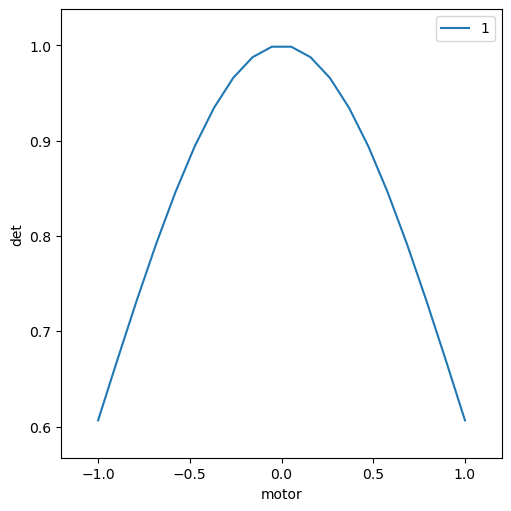

In [21]:
RE(
    scan([det], motor, -1, 1, num=20)
)



Transient Scan ID: 2     Time: 2024-08-26 13:40:05
Persistent Unique Scan ID: '4d0fe465-30d1-4b4a-b5e6-f5c6d72a9a10'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 13:40:05.9 |     -5.000 |      0.000 |
|         2 | 13:40:06.0 |     -4.474 |      0.000 |
|         3 | 13:40:06.0 |     -3.947 |      0.000 |
|         4 | 13:40:06.1 |     -3.421 |      0.003 |
|         5 | 13:40:06.3 |     -2.895 |      0.015 |
|         6 | 13:40:06.4 |     -2.368 |      0.061 |
|         7 | 13:40:06.5 |     -1.842 |      0.183 |
|         8 | 13:40:06.6 |     -1.316 |      0.421 |
|         9 | 13:40:06.7 |     -0.789 |      0.732 |
|        10 | 13:40:06.8 |     -0.263 |      0.966 |
|        11 | 13:40:06.9 |      0.263 |      0.966 |
|        12 | 13:40:06.9 |      0.789 |      0.732 |
|        13 | 13:40:07.0 |      1.316 |      0.421 |
|        14

('4d0fe465-30d1-4b4a-b5e6-f5c6d72a9a10',)

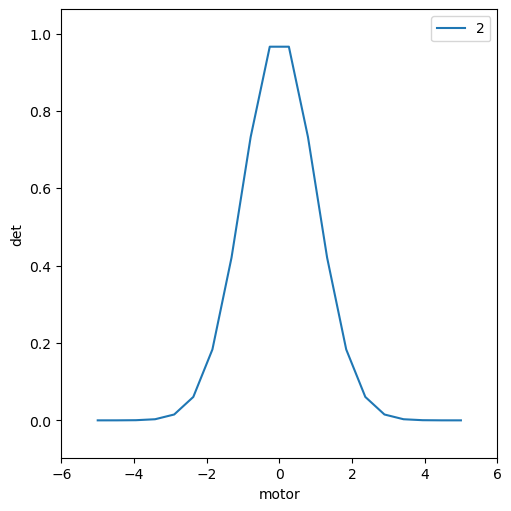

In [22]:
RE(
    scan([det], motor, -5, 5, num=20)
)



Transient Scan ID: 3     Time: 2024-08-26 13:40:08
Persistent Unique Scan ID: '16a48145-d173-48d5-b6a3-3a1279a94669'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 13:40:08.6 |     -5.000 |      0.000 |
|         2 | 13:40:08.7 |     -4.899 |      0.000 |
|         3 | 13:40:08.8 |     -4.798 |      0.000 |
|         4 | 13:40:08.8 |     -4.697 |      0.000 |
|         5 | 13:40:08.9 |     -4.596 |      0.000 |
|         6 | 13:40:09.0 |     -4.495 |      0.000 |
|         7 | 13:40:09.1 |     -4.394 |      0.000 |
|         8 | 13:40:09.2 |     -4.293 |      0.000 |
|         9 | 13:40:09.3 |     -4.192 |      0.000 |
|        10 | 13:40:09.3 |     -4.091 |      0.000 |
|        11 | 13:40:09.4 |     -3.990 |      0.000 |
|        12 | 13:40:09.6 |     -3.889 |      0.001 |
|        13 | 13:40:09.7 |     -3.788 |      0.001 |
|        14

('16a48145-d173-48d5-b6a3-3a1279a94669',)

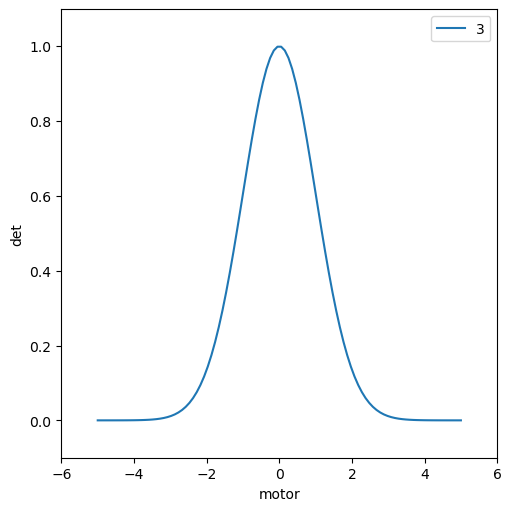

In [23]:
RE(
    scan([det], motor, -5, 5, num=100)
)

## Relative Scan



Transient Scan ID: 4     Time: 2024-08-26 13:40:18
Persistent Unique Scan ID: 'efb859f7-a3af-4f8e-a4e3-37797681b8a8'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 13:40:18.1 |      2.000 |      0.135 |
|         2 | 13:40:18.2 |      2.041 |      0.125 |
|         3 | 13:40:18.3 |      2.082 |      0.115 |
|         4 | 13:40:18.3 |      2.122 |      0.105 |
|         5 | 13:40:18.4 |      2.163 |      0.096 |
|         6 | 13:40:18.5 |      2.204 |      0.088 |
|         7 | 13:40:18.6 |      2.245 |      0.080 |
|         8 | 13:40:18.7 |      2.286 |      0.073 |
|         9 | 13:40:18.8 |      2.327 |      0.067 |
|        10 | 13:40:18.9 |      2.367 |      0.061 |
|        11 | 13:40:19.0 |      2.408 |      0.055 |
|        12 | 13:40:19.1 |      2.449 |      0.050 |
|        13 | 13:40:19.2 |      2.490 |      0.045 |
|        14 | 13:40:19.2 |      2.531 |      0.041 |
|        15 | 13:40:19.3 |      2.571 |      0.037 |
|        16 | 13:40:19.4

('efb859f7-a3af-4f8e-a4e3-37797681b8a8',)

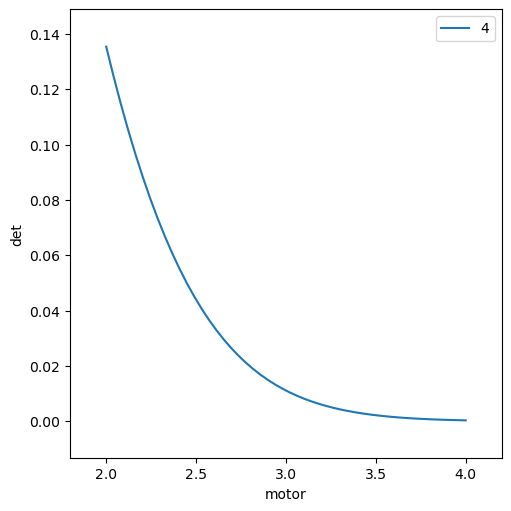

In [24]:
RE(mv(motor, 3))
RE(
    rel_scan([det], motor, -1, 1, num=50)
)

## List Scan



Transient Scan ID: 5     Time: 2024-08-26 13:40:23
Persistent Unique Scan ID: '4fe5b479-c3c4-4a6e-8881-86cb53626609'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 13:40:23.4 |     -1.400 |      0.375 |
|         2 | 13:40:23.5 |     -1.300 |      0.430 |
|         3 | 13:40:23.5 |     -0.800 |      0.726 |
|         4 | 13:40:23.6 |     -0.700 |      0.783 |
|         5 | 13:40:23.7 |     -0.200 |      0.980 |
|         6 | 13:40:23.8 |     -0.100 |      0.995 |
+-----------+------------+------------+------------+
generator list_scan ['4fe5b479'] (scan num: 5)





('4fe5b479-c3c4-4a6e-8881-86cb53626609',)

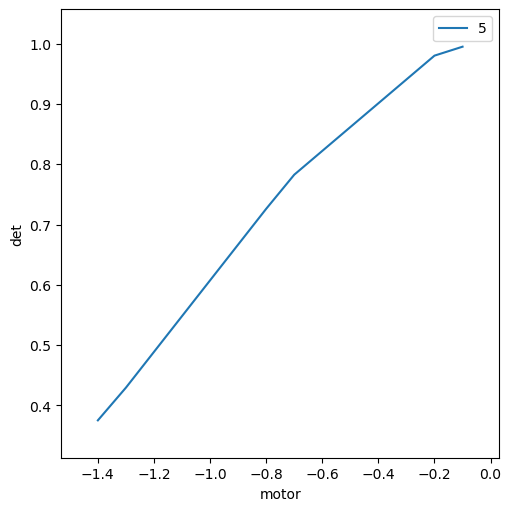

In [25]:
RE(
    list_scan([det], motor, [-1.4, -1.3, -0.8, -0.7, -0.2, -0.1])
)



Transient Scan ID: 6     Time: 2024-08-26 13:40:24
Persistent Unique Scan ID: '683a50e1-c467-460c-94b6-5cb5c912da4b'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 13:40:24.5 |      1.600 |      0.278 |
|         2 | 13:40:24.7 |      1.700 |      0.236 |
|         3 | 13:40:24.8 |      2.200 |      0.089 |
|         4 | 13:40:24.9 |      2.300 |      0.071 |
|         5 | 13:40:25.0 |      2.800 |      0.020 |
|         6 | 13:40:25.2 |      2.900 |      0.015 |
+-----------+------------+------------+------------+
generator rel_list_scan ['683a50e1'] (scan num: 6)





('683a50e1-c467-460c-94b6-5cb5c912da4b',)

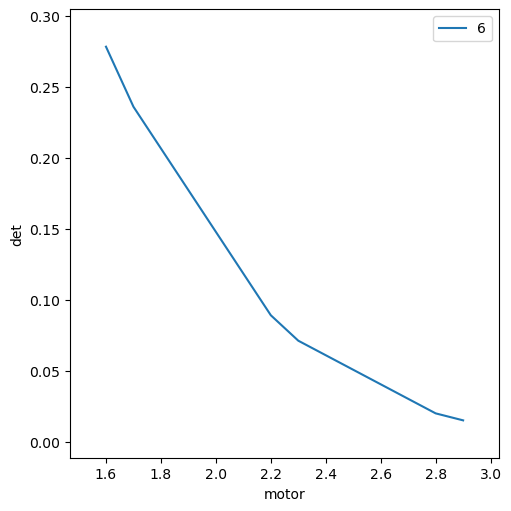

In [26]:
RE(mv(motor, 3))
RE(
    rel_list_scan([det], motor, [-1.4, -1.3, -0.8, -0.7, -0.2, -0.1])
)